In [18]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [20]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
print(torch.randperm(400, dtype=torch.int).type())

torch.IntTensor


In [22]:
listdirs = ["Healthy", "Motor_1_Steady_state_error", "Motor_1_Stuck", "Motor_2_Steady_state_error", "Motor_2_Stuck", "Motor_3_Steady_state_error", "Motor_3_Stuck", "Motor_4_Steady_state_error", "Motor_4_Stuck"]
path = "training_csv/"
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, training_ratio:float, path, directories_list, backend, number_files:int = 400):
        super().__init__()
        self.path = path
        self.backend = backend
        self.training_ratio = training_ratio
        self.directories_list = directories_list
        self.simulations_train = torch.Tensor([])
        self.classes_train = torch.Tensor([])
        self.simulations_test = torch.Tensor([])
        self.classes_test = torch.Tensor([])
        self.number_files = number_files

        num_training = int(training_ratio*number_files)

        for i, folder in enumerate(self.directories_list):
            folderpath = os.path.join(path, folder)
            with os.scandir(folderpath) as it:
                temp_simulations = []
                temp_classes = []
                for n, file in enumerate(it):
                    open_file = pd.read_csv(file.path)
                    tensor = torch.tensor(open_file.values, dtype=torch.float32)
                    tensor[:,3:] -= tensor[:,:3]
                    standardized_tensor = (tensor - tensor.mean(dim=0, keepdim=True))/tensor.std(dim=0, keepdim=True)
                    temp_simulations.append(standardized_tensor)
                    temp_classes.append(torch.nn.functional.one_hot(torch.tensor([i]), num_classes=9)[0].type(torch.float16))
            rand_perm = torch.randperm(400,  dtype=torch.int)
            temp_simulations = torch.stack(temp_simulations)[rand_perm]
            temp_classes = torch.stack(temp_classes)[rand_perm]
            self.simulations_train = torch.cat((self.simulations_train, temp_simulations[:num_training]))
            self.classes_train = torch.cat((self.classes_train, temp_classes[:num_training]))
            self.simulations_test = torch.cat((self.simulations_test, temp_simulations[num_training:]))
            self.classes_test = torch.cat((self.classes_test, temp_classes[num_training:]))


    def __len__(self):
        return len(self.simulations_train)

    def __getitem__(self, index):
        return (self.simulations_train[index], self.classes_train[index])

simul_dataset = Dataset(training_ratio=0.9, path=path, directories_list=listdirs, backend=device)
trainingloader = torch.utils.data.DataLoader(simul_dataset, batch_size=32)

In [24]:
print(simul_dataset.simulations_train.shape, simul_dataset.simulations_test.shape, simul_dataset.classes_train.shape, simul_dataset.classes_test.shape)

torch.Size([3240, 999, 6]) torch.Size([360, 999, 6]) torch.Size([3240, 9]) torch.Size([360, 9])


In [29]:
class LSTM_model(nn.Module):
    def __init__(self, hidden_size, backend):
        super().__init__()
        self.hidden_size = hidden_size
        self.backend = backend

        self.LSTM = nn.LSTM(input_size=6, hidden_size=self.hidden_size, dropout=0.1, device=self.backend, batch_first=True, num_layers=2)
        self.Linear = nn.Linear(in_features=self.hidden_size, out_features=9, device=self.backend)

    def forward(self, x):
        x = self.LSTM(x)[0][:,-1]
        x = self.Linear(x)
        return x

Lstm = LSTM_model(100, device)

In [30]:
loss_function = torch.nn.CrossEntropyLoss()
epochs = 250
accuracy = 0
F1 = np.zeros(9)
training_data = [[], []]

In [36]:
optimizer = torch.optim.Adam(Lstm.parameters(), lr=1E-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.5)

In [37]:
for e in range(epochs):
    Lstm.train()
    correct = 0
    for i, data in enumerate(trainingloader):
        optimizer.zero_grad()
        predictions = Lstm.forward(data[0].to(device))
        true_results = data[1].to(device)

#        print(predictions.shape, true_results.shape)
        cost = loss_function(predictions, true_results)
        for n in range(len(predictions)):
            if torch.argmax(predictions[n]) == torch.argmax(true_results[n]):
                correct += 1

        cost.backward()

        optimizer.step()

    print(f"Epoch : {e+1}, training cost : {cost}, accuracy : {round(correct/3240*100, 3)}")

    Lstm.eval()
    with torch.no_grad():
        correct = 0
        VP = FN = FP = np.zeros(9)

        test_predictions = torch.argmax(Lstm.forward(simul_dataset.simulations_test.to(device)), dim=-1)
        answers = torch.argmax(simul_dataset.classes_test.to(device), dim=-1)
        for n in range(len(answers)):
            if test_predictions[n] == answers[n]:
                correct += 1
                VP[answers[n]] += 1
            else:
                FN[answers[n]] += 1
                FP[test_predictions[n]] += 1
        precision = np.divide(VP, VP+FP)
        recall = np.divide(VP, VP+FN)
        accuracy = correct/360
        F1 = 2*np.divide(np.multiply(precision, recall), precision+recall)
        training_data[0].append(accuracy)
        training_data[1].append(F1)
        scheduler.step()
        print(f"Accuracy : {round(accuracy*100, 2)}%, F1 score : {F1}, lr : {scheduler.get_last_lr()}")


Epoch : 1, training cost : 1.5341142416000366, accuracy : 30.586
Accuracy : 12.22%, F1 score : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5], lr : [0.001]
Epoch : 2, training cost : 1.8576178550720215, accuracy : 18.92
Accuracy : 13.33%, F1 score : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5], lr : [0.001]


KeyboardInterrupt: 

In [ ]:
VP = FN = FP = np.zeros(9)
correct = 0
for i, images in enumerate(trainingloader):
    predictions = torch.argmax(model_temp.forward(images[0].to(device)), dim=1)
    true_results = torch.argmax(images[1].to(device), dim=1)

    for n, prediction in enumerate(predictions):
        if prediction == true_results[n]:
            VP[true_results[n]] += 1
            correct += 1
        else:
            FN[true_results[n]] += 1
            FP[prediction] += 1

precision = VP/(VP+FP)
recall = VP/(VP+FN)
accuracy = correct/len(training_set)
F1 = (2*precision*recall)/(precision+recall)
print(f"Accuracy : {accuracy*100}%", f"F1 score : {F1}, {VP, FN, FP}")

Accuracy : 12.12962962962963% F1 score : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5], (array([ 360.,  361.,  422.,  386., 2706.,  361.,  750.,  360.,  381.]), array([ 360.,  361.,  422.,  386., 2706.,  361.,  750.,  360.,  381.]), array([ 360.,  361.,  422.,  386., 2706.,  361.,  750.,  360.,  381.]))


In [ ]:
Lstm.zero_grad()
VP = FP = FN = np.zeros(9)
correct = 0
for i, data in enumerate(testingloader):
    predictions = Lstm.forward(data[0].to(device))

    for n, prediction in enumerate(predictions):
        response = torch.argmax(prediction)
        true_result = torch.argmax(data[1][n])
        if response == true_result:
            VP[true_result] += 1
            correct += 1
        else:
            FP[response] += 1
            FN[true_result] += 1

precision = VP/(VP+FP)
recall = VP/(VP+FN)
print(f"Accuracy : {correct/360*100} ‰", f"F1 score : {2*precision*recall/(precision+recall)}")

Accuracy : 33.88888888888889 ‰ F1 score : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [ ]:
torch.save(Lstm, "LSTM_model_30-03")

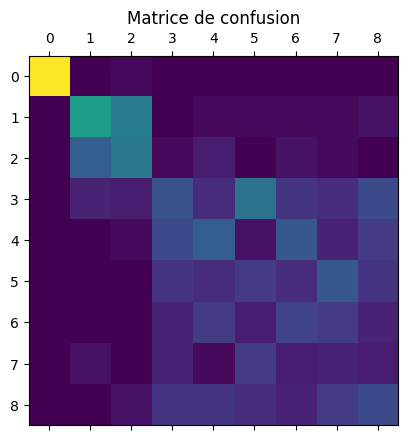

In [ ]:
results = np.zeros((9, 9))

for data in testingloader:
    predictions = Lstm.forward(data[0].to(device))

    for n, prediction in enumerate(predictions):
        results[torch.argmax(prediction)][torch.argmax(data[1][n])] += 1

figure = plt.figure()
axes = plt.axes()
axes.matshow(results)
plt.title("Matrice de confusion")
plt.show()

figure.savefig("/content/drive/MyDrive/confusion_mat")

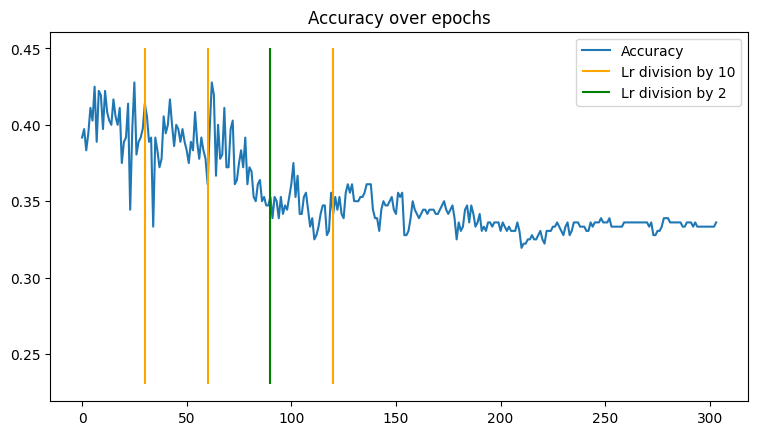

In [ ]:
figure = plt.figure(figsize=(9, 4.8))
ax = plt.axes()
ax.plot(training_data[0], label="Accuracy")
ax.vlines((30, 60, 120), ymin=0.23, ymax=0.45, label="Lr division by 10", color="orange")
ax.vlines(90, ymin=0.23, ymax=0.45, label="Lr division by 2", color="green")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()
figure.savefig("/content/drive/MyDrive/accuracy")